In [1]:
from google.colab import drive
drive.mount('/content/drive/')
from pandas import DataFrame, Series
import pandas as pd
import glob
import re
from tqdm import tqdm
import torchaudio
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle
import os
import glob
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from keras.models import load_model
from IPython.display import Audio
from IPython.core.display import display
import time
import librosa
from joblib import dump, load
import numpy as np
from numpy import dot
from numpy.linalg import norm
import cv2

Mounted at /content/drive/


In [3]:
# "belt": 0, "straight": 1, "vibrato": 2, "vocal_fry": 3
sec = [[5,6], [8,9], [13, 14], [16,17], [17,18], [19,20], [25, 26], [27, 28], [28, 29], [30, 31], [32,33], [36,37], [38,39], [47,48], [49,50], [52,53], [58,59],
       [74,75], [79,80], [80,81], [85,86], [89,90], [93, 94],[95,95.5],[95.5,96], [96,97], [98,99], [99,100], [102,103], [104,105], [107,108], [113,114], [115,116],[118,119], [124,125],
       [141,142], [146,147],[148,149],[153,154],[160,160.5],[162,163],[170,171],[173,174]]

pre_sec = [[6.1,6.5],[9.1,9.5],[13.2,13.6],[16.8,17.2],[17.2,17.6],[20.1,20.5],[25.3,25.7],[27.8,28.2],[29.2,29.6],[30.6,31],[32.1,32.5],
           [36.1,36.5],[38.9,39.3],[47.5,47.9],[49.8,50.2],[52.2,52.6],[58.6,59.0],
           [74.6,75.0],[80.0,80.4],[80.3,80.7],[85.6,86.0],[89.8,90.2],[94.1,94.5],[95.4,95.8],[96.0,96.4],[96.9,97.3],[98.2,98.6],[99.5,99.9],[102.5,102.9],[105.1,105.5],[107.0,107.4],[113.7,114.1],[116.0,116.4],[118.4,118.8],[124.8,125.2],
           [141.7,142.1],[146.7,147.1],[148.9,149.3],[153.5,153.9],[160.3,160.7],[162.6,163.0],[171.2,171.6],[173.9,174.3]]
label = ["vocal_fry","vocal_fry","vocal_fry","vocal_fry","vocal_fry","vocal_fry","vibrato","belt",'belt','belt','vibrato','vibrato', 'belt','vibrato','belt','belt','vibrato',
         "vocal_fry","vocal_fry","vibrato","vocal_fry","vocal_fry",'belt','belt',"vocal_fry",'belt','vibrato', "vocal_fry",'belt','belt','belt','vibrato','belt','belt','vibrato',
         "vocal_fry", 'vibrato','vibrato','vibrato',
         'belt','belt','belt','belt']
lyrics = ['찢', '아', 'So' , 'Yeah', '나', '넌', '해', '하', '달', '쯤', '면', '가', '나는', '고', '아직은', '바보처럼', '어',
          '어','Some', 'Thin', '뭐', '움', '하', '한달', '일', '그', '면', '웃', '만', '나는', '쉽지않을 것 같', '고', '아직은', '바보처럼', '어',
          '는', '아', '보', '며', '우리', '그순간이', '아직은', '바보처럼']

sample_data = pd.DataFrame({'sec' : pre_sec, 'label' : label, 'lyrics' : lyrics})
sample_data.to_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/sample_fine_data.csv", index = False)

# 1. Data Imports

In [ ]:
fine,sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/fine.wav", sr = 44100)
yj_fine_mr,sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine.wav", sr = 44100)
yj_fine_straight_mr,sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight.wav", sr = 44100)
migyo_fine_mr,sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/migyo_fine.wav", sr = 44100)
mr, sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/Fine-Melody.mp3", sr = 44100)

In [ ]:
import nussl
def remove_mr(data):
  signal = nussl.AudioSignal(
      audio_data_array=data, sample_rate=44100)
  ft2d = nussl.separation.primitive.FT2D(signal)
  ft2d_bg, ft2d_fg = ft2d()
  return ft2d_fg.audio_data[0]

# fine_mr, fine_vocal은 이미 만들어진 상태
yj_fine_vocal = remove_mr(yj_fine_mr)
migyo_fine_vocal = remove_mr(migyo_fine_mr)
# mr_removed = remove_mr(mr) # 얘는 mr제거라고 할 수 없음!
yj_fine_straight_vocal = remove_mr(yj_fine_straight_mr)

# 2. Making 0.4 Datas

In [ ]:
# 정확한 0.4초 확인하기 위한 코드
for i in sec[42:]:
  a,b = i[0],i[1]+1
  display(Audio(data = fine[int((a)*44100) : int((b)*44100)], rate = 44100))
  idx = 0
  while a+idx+0.4 <= b:
    print(a+idx)
    print(a+idx+0.4)
    display(Audio(data = fine[int((a+idx)*44100) : int((a+idx+0.4)*44100)], rate = 44100))
    idx+=0.1

In [ ]:
# yj_fine mr버전 저장
yj_fine_with_mr = []
for i in pre_sec:
  diff = -1.2
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = yj_fine_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  yj_fine_with_mr.append(yj_fine_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : yj_fine_with_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_mr.pkl")

In [ ]:
# yj_fine mr버전 저장
yj_fine_without_mr = []
for i in pre_sec:
  diff = -1.2
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = yj_fine_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  yj_fine_without_mr.append(yj_fine_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : yj_fine_without_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_vocal.pkl")

In [ ]:
# yj_fine straight mr버전 저장
yj_fine_straight_with_mr = []
for i in pre_sec:
  diff = -0.9
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = yj_fine_straight_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  yj_fine_straight_with_mr.append(yj_fine_straight_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : yj_fine_straight_with_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight_mr.pkl")

In [ ]:
# yj_fine staight mr버전 저장
yj_fine_straight_without_mr = []
for i in pre_sec:
  diff = -0.9
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = yj_fine_straight_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  yj_fine_straight_without_mr.append(yj_fine_straight_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : yj_fine_straight_without_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight_vocal.pkl")

In [ ]:
# migyo_fine mr버전 저장
migyo_fine_with_mr = []
for i in pre_sec:
  diff = -0.3
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = migyo_fine_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  migyo_fine_with_mr.append(migyo_fine_mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : migyo_fine_with_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/migyo_fine_mr.pkl")

In [ ]:
# migyo_fine mr버전 저장
migyo_fine_without_mr = []
for i in pre_sec:
  diff = -0.3
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = migyo_fine_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  migyo_fine_without_mr.append(migyo_fine_vocal[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : migyo_fine_without_mr,"label" : label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/migyo_fine_vocal.pkl")

In [ ]:
mr,sr = librosa.load("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/Fine-Melody.mp3", sr = 44100)
Audio(data = mr, rate = 44100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# mr버전 저장
mr_data = []
for i in pre_sec:
  diff = 0.4
  print(i[0] + diff, i[1] + diff)
  display(Audio(data = mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)], rate = 44100))
  mr_data.append(mr[int((i[0] + diff)*44100) : int((i[1] + diff)*44100)])
tmp_df = pd.DataFrame({"data" : mr_data,"label" : ["straight" for _ in range(len(mr_data))]})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/mr.pkl")

In [ ]:
mr_sec = [[  6.5,   6.9],[  9.5,   9.9],[ 13.6,  14. ],[ 17.2,  17.6],[ 17.6,  18. ],[ 20.5,  20.9],
          [ 25.7,  26.1],[ 28.2,  28.6],[ 29.6,  30. ],[ 31. ,  31.4],[ 32.5,  32.9],[ 36.5,  36.9],
          [ 39.3,  39.7],[ 47.9,  48.3],[ 50.2,  50.6],[ 52.6,  53. ],[ 59. ,  59.4],
          [ 75. ,  75.4],[ 80.4,  80.8],[ 80.7,  81.1],[ 86. ,  86.4],[ 90.2,  90.6],
          [ 94.5,  94.9],[ 95.8,  96.2],[ 96.4,  96.8],[ 97.3,  97.7],[ 98.6,  99. ],
          [ 99.9, 100.3],[102.9, 103.3],[105.5, 105.9],[107.4, 107.8],[114.1, 114.5],
          [116.4, 116.8],[118.8, 119.2],[125.2, 125.6],[142.1, 142.5],[147.1, 147.5],
          [149.3, 149.7],[153.9, 154.3],[160.7, 161.1],[163. , 163.4],[171.6, 172. ],
          [174.3, 174.7]]

# 3. 배열 유사도

In [ ]:
from sklearn.preprocessing import StandardScaler
train_data = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/pkl_data/train_data.pkl")
scaler = StandardScaler()
train_tmp = []
for i in train_data.audio:
    train_tmp.append(i)
scaler.fit(train_tmp)

import pickle
pickle.dump(scaler, open("/content/drive/MyDrive/Startup_Hackathon_Jarvis/scaler.pkl",'wb'))

sc = pickle.load(open("/content/drive/MyDrive/Startup_Hackathon_Jarvis/scaler.pkl",'rb'))

In [ ]:
sc = joblib.load()

In [ ]:
fine_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/fine_mr.pkl")
yj_fine_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_mr.pkl")
yj_fine_straight_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight_mr.pkl")
migyo_fine_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/migyo_fine_mr.pkl")
mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/mr.pkl")
fine_vocal_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/fine_vocal.pkl")
yj_fine_vocal_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_vocal.pkl")
yj_fine_straight_vocal_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight_vocal.pkl")
migyo_fine_vocal_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/migyo_fine_vocal.pkl")

In [ ]:
def standardize(df):
  tmp_list = []
  for i in df.data:
    if len(i) == 17639:
        tmp = np.append(i, [0])
    elif len(i) == 17641:
        tmp = i[:17640]
    else:
        tmp = i
    tmp_list.append(scaler.transform(tmp.reshape(1,-1)))
  return tmp_list

In [ ]:
mr_df_std.data[0]

(1, 17640)

In [ ]:
mr_df_std = pd.DataFrame({"data" : mr_audio})
mr_df_std.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/mr_std.pkl")

In [ ]:
fine_mr_audio = standardize(fine_mr_df)
yj_fine_straight_mr_audio = standardize(yj_fine_straight_mr_df)
migyo_fine_mr_audio = standardize(migyo_fine_mr_df)
mr_audio = standardize(mr_df)

yj_fine_mr_audio = standardize(yj_fine_mr_df)
yj_fine_straight_vocal_audio = standardize(yj_fine_straight_mr_df)
fine_vocal_audio = standardize(fine_vocal_df)
yj_fine_vocal_audio = standardize(yj_fine_vocal_df)
migyo_fine_vocal_audio = standardize(migyo_fine_vocal_df)

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [ ]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def compare_similarity(name, a,b,idx):
  print(f"label : {label[idx]}")
  print(f"{name} : {cos_sim(a[idx][0], b[idx][0])}")
  print("*"*10)

In [ ]:
a = mr[int((5.1)*44100) : int((5.1)*44100) + 17640]
b = mr[int((5.2)*44100) : int((5.2)*44100) + 17640]
print("mr배열끼리 비교",cos_sim(a, b))

mr배열끼리 비교 0.13985491


In [ ]:
compare_similarity("mr과 태연fine 비교", fine_mr_audio,mr_audio,1)
compare_similarity("mr과 미교fine 비교", migyo_fine_mr_audio,mr_audio,1)
compare_similarity("mr과 유진fine straigt 비교", yj_fine_mr_audio,mr_audio,1)

label : vocal_fry
mr과 태연fine 비교 : 0.020125649869441986
**********
label : vocal_fry
mr과 미교fine 비교 : -0.05444490909576416
**********
label : vocal_fry
mr과 유진fine straigt 비교 : 0.010129892267286777
**********


In [ ]:
#@title ✅ 목소리 때문인지 유진+기술X 와 태연fine 유사도가 더 높게나옴ㅠㅠ 배열 유사도는 사용하기 힘들 것 같다..! -> AI를 어떻게든 만들어내야한다,,,
compare_similarity("태연fine과 미교fine 비교", fine_mr_audio,migyo_fine_mr_audio,4)
compare_similarity("태연fine과 유진fine staight 비교", yj_fine_straight_mr_audio,migyo_fine_mr_audio,4)

In [ ]:
#@title ✅ 목소리가 달라서 같은 구간에서 같은 보컬기술을 썼더라도 코사인 유사도는 현저히 낮게 나옴..(미교와 태연 배열 유사도를 보면 알 수 있음)
compare_similarity("태연fine과 미교fine 비교", fine_mr_audio,migyo_fine_mr_audio,1)
compare_similarity("태연fine과 유진fine staight 비교", yj_fine_straight_mr_audio,migyo_fine_mr_audio,1)

In [ ]:
for i in range(len(fine_mr_audio)):
  compare_similarity(f"{i}번째 태연fine과 미교fine 비교", fine_mr_audio,migyo_fine_mr_audio,i)
  compare_similarity(f"{i}번째 태연fine과 유진fine staight 비교", yj_fine_straight_mr_audio,migyo_fine_mr_audio,i)

In [ ]:
#@title ✅ mr제거를 해본다면?! -> 코사인 유사도도 정말 낮고,,,기술을 사용하지 않은 벡터와 유사도가 더 높다,,,,
compare_similarity("태연fine과 미교fine 비교", fine_vocal_audio,migyo_fine_vocal_audio,1)
compare_similarity("태연fine과 유진fine staight 비교", yj_fine_straight_vocal_audio,migyo_fine_vocal_audio,1)

label : vocal_fry
태연fine과 미교fine 비교 : 0.06794117120527951
**********
label : vocal_fry
태연fine과 유진fine staight 비교 : 0.1274933470617588
**********


In [ ]:
mr_audio[0].shape

(1, 17640)

In [ ]:
#@title ✅ 전체 배열 출력하기
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
yj_fine_mr_audio[0][0]

# 4. make new mr data

In [ ]:
audio_data = pd.read_csv("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/audio_data_list_2.csv")

In [ ]:
tmp_list = []
for tmp in audio_data.audio:
  tmp_list.append(list(map(float, tmp[1:-1].split(","))))
tmp_df = pd.DataFrame({'data' : tmp_list, 'label' : audio_data.label})
tmp_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_data_2.pkl")

# 5. check mr data cosine similarity

In [ ]:
mr1 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_ios.pkl")
mr2 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_data_1.pkl")
mr3 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_data_2.pkl")
fine_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/fine_mr.pkl")

In [ ]:
sc = pickle.load(open("/content/drive/MyDrive/Startup_Hackathon_Jarvis/scaler.pkl",'rb'))
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))
def compare_similarity(name, a,b,idx):
  print(f"label : {label[idx]}")
  print(f"{name} : {cos_sim(a[idx], b[idx])}")
  # print("*"*10)
# ex) compare_similarity("mr과 태연fine 비교", fine_mr_audio,mr_audio,1)

In [ ]:
for i in [mr1.data, mr2.data, mr3.data]:
  idx = 0
  display(Audio(data = i[idx], rate = 44100))

### mr 파일들 비교 (정규화 X)
+ 같은 초를 기준으로 자른 파일이지만 잘린 부분이 조금씩 다르다..!

In [ ]:
# before scaler
tmp = []
for i in range(len(mr1.data)):
  tmp.append(cos_sim(mr1.data[i],mr2.data[i]))
  if cos_sim(mr1.data[i],mr2.data[i]) > 0.5:
    print(i)
print("mr1, mr2 코사인 유사도 평균 : ", np.mean(tmp))
print("mr1, mr2 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr1, mr2 코사인 유사도 최댓값 : ", np.max(tmp))

1
2
3
4
5
6
7
8
9
10
11
38
39
40
41
42
mr1, mr2 코사인 유사도 평균 :  0.3671875539542025
mr1, mr2 코사인 유사도 최솟값 :  -0.12673058280693153
mr1, mr2 코사인 유사도 최댓값 :  0.9654562659996708


In [ ]:
# before scaler
tmp = []
for i in range(len(mr1.data)):
  tmp.append(cos_sim(mr1.data[i],mr3.data[i]))
  if cos_sim(mr1.data[i],mr3.data[i]) > 0.5:
    print(i)
print("mr1, mr3 코사인 유사도 평균 : ", np.sum(tmp)/len(tmp))
print("mr1, mr3 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr1, mr3 코사인 유사도 최댓값 : ", np.max(tmp))

mr1, mr3 코사인 유사도 평균 :  -0.03233909476832613
mr1, mr3 코사인 유사도 최솟값 :  -0.3515942197111002
mr1, mr3 코사인 유사도 최댓값 :  0.26117793304962406


In [ ]:
# before scaler
tmp = []
for i in range(len(mr1.data)):
  tmp.append(cos_sim(mr2.data[i],mr3.data[i]))
  if cos_sim(mr2.data[i],mr3.data[i]) > 0.5:
    print(i)
print("mr2, mr3 코사인 유사도 평균 : ", np.sum(tmp)/len(tmp))
print("mr2, mr3 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr2, mr3 코사인 유사도 최댓값 : ", np.max(tmp))

0
mr2, mr3 코사인 유사도 평균 :  -0.033409922876870606
mr2, mr3 코사인 유사도 최솟값 :  -0.39064345024393565
mr2, mr3 코사인 유사도 최댓값 :  0.9744585468697408


### mr 파일들 비교 (정규화 O)
+ ㅎㅎ 정규화 하든 안하든 결과는 같음. 당연함. ㅎㅎ


In [ ]:
# after scaler
tmp = []
for i in range(len(mr1.data)):
  mr1_tmp = sc.transform(np.reshape(mr1.data[i], (1,-1)))
  mr2_tmp = sc.transform(np.reshape(mr2.data[i], (1,-1)))
  tmp.append(cos_sim(mr1_tmp[0],mr2_tmp[0]))
  if cos_sim(mr1_tmp[0],mr2_tmp[0]) > 0.5:
    print(i)
print("mr1, mr2 코사인 유사도 평균 : ", np.mean(tmp))
print("mr1, mr2 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr1, mr2 코사인 유사도 최댓값 : ", np.max(tmp))

1
2
3
4
5
6
7
8
9
10
11
38
39
40
41
42
mr1, mr2 코사인 유사도 평균 :  0.36730447580649317
mr1, mr2 코사인 유사도 최솟값 :  -0.12593203505005726
mr1, mr2 코사인 유사도 최댓값 :  0.965488569177307


In [ ]:
# after scaler
tmp = []
for i in range(len(mr1.data)):
  mr1_tmp = sc.transform(np.reshape(mr1.data[i], (1,-1)))
  mr3_tmp = sc.transform(np.reshape(mr3.data[i], (1,-1)))
  tmp.append(cos_sim(mr1_tmp[0],mr3_tmp[0]))
  if cos_sim(mr1_tmp[0],mr3_tmp[0]) > 0.5:
    print(i)
print("mr1, mr3 코사인 유사도 평균 : ", np.mean(tmp))
print("mr1, mr3 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr1, mr3 코사인 유사도 최댓값 : ", np.max(tmp))

mr1, mr3 코사인 유사도 평균 :  -0.032000390412493404
mr1, mr3 코사인 유사도 최솟값 :  -0.353146755606203
mr1, mr3 코사인 유사도 최댓값 :  0.26018520330015354


In [ ]:
# after scaler
tmp = []
for i in range(len(mr1.data)):
  mr2_tmp = sc.transform(np.reshape(mr2.data[i], (1,-1)))
  mr3_tmp = sc.transform(np.reshape(mr3.data[i], (1,-1)))
  tmp.append(cos_sim(mr2_tmp[0],mr3_tmp[0]))
  if cos_sim(mr2_tmp[0],mr3_tmp[0]) > 0.5:
    print(i)
print("mr2, mr3 코사인 유사도 평균 : ", np.mean(tmp))
print("mr2, mr3 코사인 유사도 최솟값 : ", np.min(tmp))
print("mr2, mr3 코사인 유사도 최댓값 : ", np.max(tmp))

0
mr2, mr3 코사인 유사도 평균 :  -0.03309917040980011
mr2, mr3 코사인 유사도 최솟값 :  -0.3922104372459881
mr2, mr3 코사인 유사도 최댓값 :  0.9743651321344249


# 6. check mr data mel-spec similarity with **Gray scale Histogram**





In [ ]:
import cv2
mr1 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_ios.pkl")
mr2 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_data_1.pkl")
mr3 = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_data_2.pkl")
fine_mr_df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/fine_data/yj_fine_straight_mr.pkl")

In [ ]:
for i in range(len(fine_mr_df)):
  if len(fine_mr_df.data[i]) == 17639:
    fine_mr_df.data[i] = np.append(fine_mr_df.data[i], 0)
  elif len(fine_mr_df.data[i]) == 17641:
    fine_mr_df.data[i] = fine_mr_df.data[i][:-1]

In [ ]:
sc = pickle.load(open("/content/drive/MyDrive/Startup_Hackathon_Jarvis/scaler.pkl",'rb'))
for i in range(len(mr1)):
  mr1.data[i] = np.squeeze(sc.transform(np.reshape(mr1.data[i], (1,-1))))
  mr2.data[i] = np.squeeze(sc.transform(np.reshape(mr2.data[i], (1,-1))))
  mr3.data[i] = np.squeeze(sc.transform(np.reshape(mr3.data[i], (1,-1))))
  fine_mr_df.data[i] = np.squeeze(sc.transform(np.reshape(fine_mr_df.data[i], (1,-1))))

In [ ]:
for i in [mr1.data, mr2.data, mr3.data,fine_mr_df.data]:
  idx = 0
  display(Audio(data = i[idx], rate = 44100))

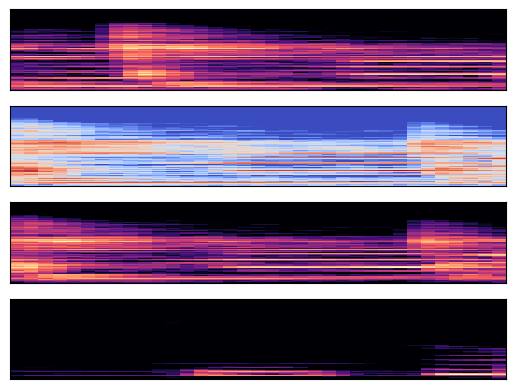

******************************


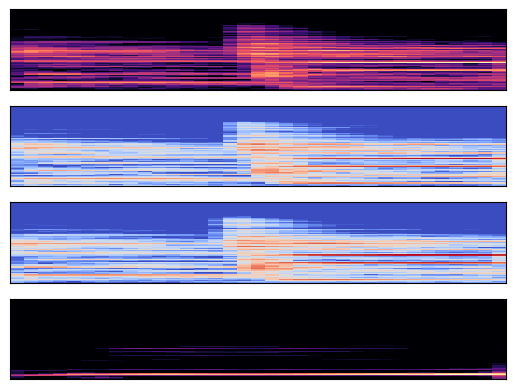

******************************


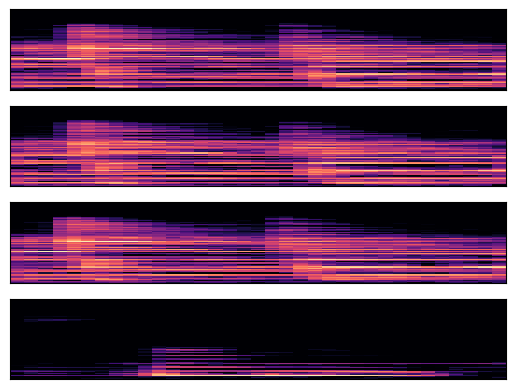

******************************


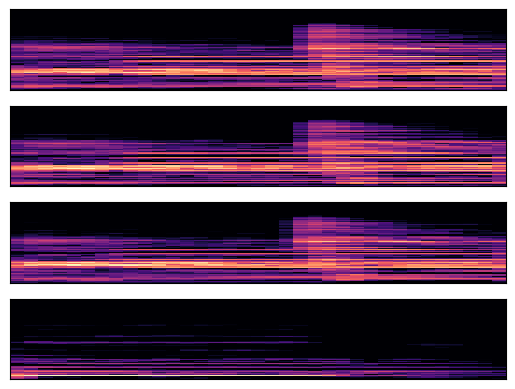

******************************


In [ ]:
for j in range(len(mr1.data)):
  fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)
  ax_idx = 0
  for i in [mr1.data, mr2.data, mr3.data, fine_mr_df.data]:
    idx = j
    ret = librosa.feature.melspectrogram(y=np.array(i[idx]),sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    librosa.display.specshow(amp, ax=ax[ax_idx])
    ax_idx += 1
  plt.show()
  print("*"*30)
  if j == 3:
    break

### 1) RGB Scale histogram 확인

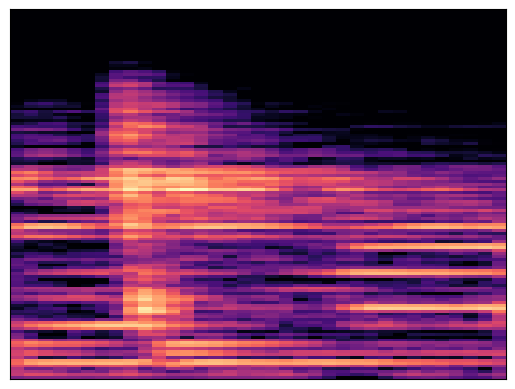

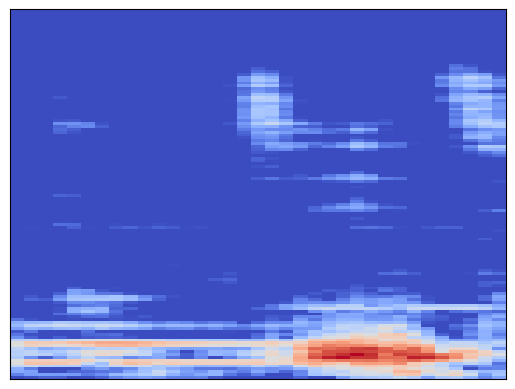

In [ ]:
fig, ax = plt.subplots()
ret = librosa.feature.melspectrogram(y=np.array(mr1.data[0]),sr = 44100)
amp = librosa.amplitude_to_db(np.abs(ret))
img = librosa.display.specshow(amp, ax = ax)
plt.savefig("./mr1_0.png")
plt.show()

fig, ax = plt.subplots()
ret = librosa.feature.melspectrogram(y=np.array(fine_mr_df.data[0]),sr = 44100)
amp = librosa.amplitude_to_db(np.abs(ret))
img = librosa.display.specshow(amp, ax = ax)
plt.savefig("./fine_0.png")
plt.show()

In [ ]:
mr1_0 = cv2.imread("./mr1_0.png")
fine_0 = cv2.imread("./fine_0.png")

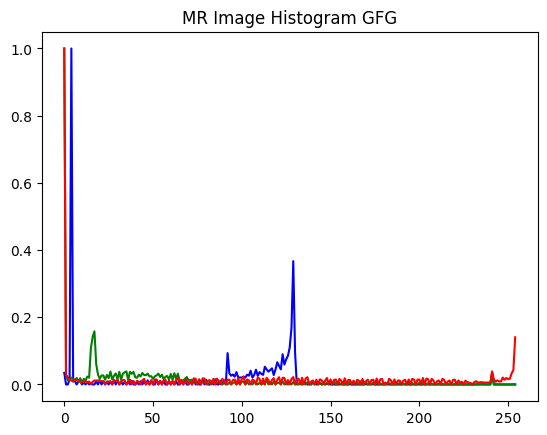

In [ ]:
colors = ('b','g','r')

# compute and plot the image histograms
for i,color in enumerate(colors):
    hist = cv2.calcHist([mr1_0],[i],None,[256],[0,256])
    hist = hist[:-1]
    hist = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    plt.plot(hist,color = color)
plt.title('MR Image Histogram GFG')
plt.show()

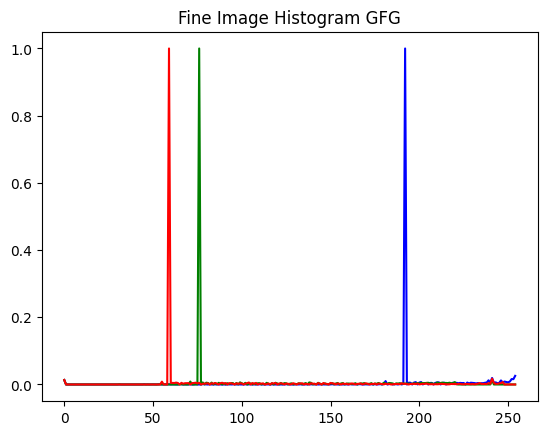

In [ ]:
colors = ('b','g','r')

# compute and plot the image histograms
for i,color in enumerate(colors):
    hist = cv2.calcHist([fine_0],[i],None,[256],[0,256])
    hist = hist[:-1]
    hist = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    plt.plot(hist,color = color)
plt.title('Fine Image Histogram GFG')
plt.show()

### 2) Gray Scale Histogram 시각화 테스트





In [ ]:
total_data = []
for i in [mr1.data, mr2.data, mr3.data, fine_mr_df.data]:
  tmp = []
  for j in range(len(i)):
    ret = librosa.feature.melspectrogram(y=np.array(i[j]),sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    tmp.append(amp)
  total_data.append(tmp)
mr1_mel, mr2_mel, mr3_mel, fine_mr_mel = total_data[0],total_data[1],total_data[2],total_data[3]

In [ ]:
print(np.min(mr3_mel[2]), np.max(mr3_mel[2]))

3.17677452634328 83.17677452634328


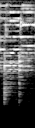

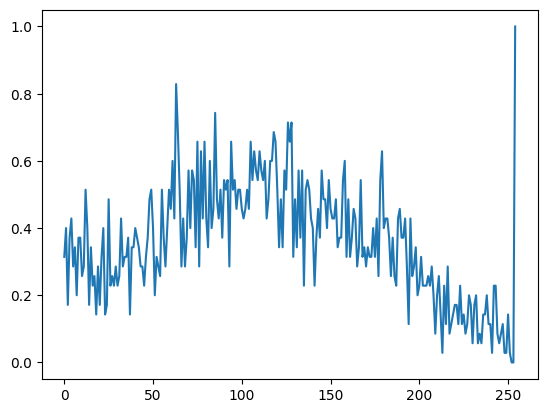

In [ ]:
from google.colab.patches import cv2_imshow
t = mr3_mel[2] - np.min(mr3_mel[2], axis = 0)
t /= np.max(t, axis = 0)
t *= 255

gray = np.expand_dims(t, axis = 2)
gray = gray.astype('float32')
cv2_imshow(gray)
hist = cv2.calcHist([gray], [0], None, [256], [0,256])
# hist = hist[1:]
# cv2_imshow(hist)
hist = hist[1:]
hist_mr = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
plt.plot(hist_mr)
# print(hist)

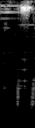

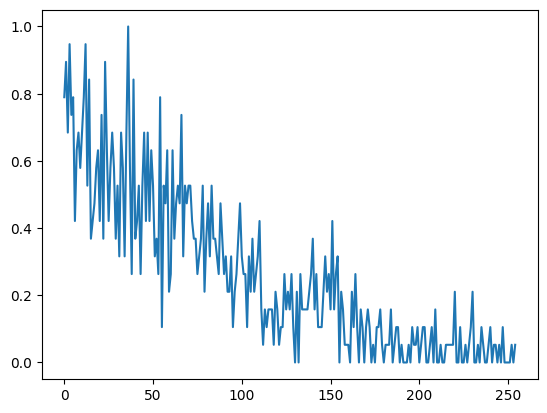

In [ ]:
from google.colab.patches import cv2_imshow
t = fine_mr_mel[0] - np.min(fine_mr_mel[0])
t /= np.max(t)
t *= 255

gray = np.expand_dims(t, axis = 2)
gray = gray.astype('float32')
cv2_imshow(gray)
hist = cv2.calcHist([gray], [0], None, [256], [0,256])
hist = hist[1:]
hist_fine = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
plt.plot(hist_fine)
#plt.plot(hist_fine)

### 3)Gray Scale Histogram 유사도 테스트

In [ ]:
methods = {'CORREL' :cv2.HISTCMP_CORREL, 'CHISQR':cv2.HISTCMP_CHISQR,
           'INTERSECT':cv2.HISTCMP_INTERSECT,
           'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}

In [ ]:
# cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
# cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)
# cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
for i, (name, flag) in enumerate(methods.items()):
    print('%-10s'%name, end='\t')
    ret = cv2.compareHist(hist_mr, hist_fine, flag)
    if flag == cv2.HISTCMP_INTERSECT: #교차 분석인 경우
        ret = ret/np.sum(hist_mr)        #비교대상으로 나누어 1로 정규화
    print("img%d:%7.2f"% (i+1 , ret), end='\t')
    print()

CORREL    	img1:   0.40	
CHISQR    	img2:  49.10	
INTERSECT 	img3:   0.51	


### 4) Gray Scale Histogram 유사도

In [ ]:
total_data = []
for i in [mr1.data, mr2.data, mr3.data, fine_mr_df.data]:
  tmp = []
  for j in range(len(i)):
    ret = librosa.feature.melspectrogram(y=np.array(i[j]),sr = 44100)
    amp = librosa.amplitude_to_db(np.abs(ret))
    tmp.append(amp)
  total_data.append(tmp)
mr1_mel, mr2_mel, mr3_mel, fine_mr_mel = total_data[0],total_data[1],total_data[2],total_data[3]

In [ ]:
def make_gray_hist(mel):
  t = mel - np.min(mel,axis = 0)
  t /= np.max(t, axis = 0)
  t *= 255

  gray = np.expand_dims(t, axis = 2)
  gray = gray.astype('float32')
  hist = cv2.calcHist([gray], [0], None, [256], [0,256])
  hist = hist[1:]
  hist_mr = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
  return hist_mr

mr1_hist, mr2_hist, mr3_hist, fine_hist = [],[],[],[]
hist_list = [mr1_hist, mr2_hist, mr3_hist, fine_hist]
for idx, mel in enumerate([mr1_mel, mr2_mel, mr3_mel, fine_mr_mel]):
  for i in range(len(mel)):
    hist_list[idx].append(make_gray_hist(mel[i]))

In [ ]:
methods = {'CORREL' :cv2.HISTCMP_CORREL,                # cv2.HISTCMP_CORREL: 상관관계 (1: 완전 일치, -1: 완전 불일치, 0: 무관계)
        'CHISQR':cv2.HISTCMP_CHISQR,                 # cv2.HISTCMP_CHISQR: 카이제곱 (0: 완전 일치, 무한대: 완전 불일치)
        'INTERSECT':cv2.HISTCMP_INTERSECT,           # cv2.HISTCMP_INTERSECT: 교차 (1: 완전 일치, 0: 완전 불일치 - 1로 정규화한 경우)
        'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}   # cv2.HISTCMP_BHATTACHARYYA 값이 작을수록 유사한 것으로 판단
def hist_similarity(hist1, hist2):
  sim = []
  for i, (name, flag) in enumerate(methods.items()):
      # print('%-10s'%name, end='\t')
      ret = cv2.compareHist(hist1, hist2, flag)
      if flag == cv2.HISTCMP_INTERSECT: #교차 분석인 경우
          ret = ret/np.sum(hist1)        #비교대상으로 나누어 1로 정규화
      sim.append(ret)
      # print("img%d:%7.2f"% (i+1 , ret), end='\t')
      # print()
  return sim

def total_hist_similarity(hist_list1, hist_list2):
  total_sim = []
  for i in range(len(hist_list1)):
    total_sim.append(hist_similarity(hist_list1[i], hist_list2[i]))
  return total_sim

In [ ]:
#@title 1️⃣ mr1, mr2, mr3 비교
mr12_sim = total_hist_similarity(mr1_hist, mr2_hist)
mr13_sim = total_hist_similarity(mr1_hist, mr3_hist)
mr23_sim = total_hist_similarity(mr2_hist, mr3_hist)

In [ ]:
for idx, name in enumerate(["correlation", "Chi-Square", "Intersection", "Bhattacharyya"]):
    mr12, mr13, mr23 = np.array(mr12_sim).T[idx], np.array(mr13_sim).T[idx], np.array(mr23_sim).T[idx]
    print(f"Mr1 & Mr2 {name} Average : ", f"{np.mean(mr12):.2f}", " Min : ", f"{np.min(mr12):.2f}", " Max : ", f"{np.max(mr12):.2f}")
    print(f"Mr1 & Mr3 {name} Average : ", f"{np.mean(mr13):.2f}", " Min : ", f"{np.min(mr13):.2f}", " Max : ", f"{np.max(mr13):.2f}")
    print(f"Mr2 & Mr3 {name} Average : ", f"{np.mean(mr23):.2f}", " Min : ", f"{np.min(mr23):.2f}", " Max : ", f"{np.max(mr23):.2f}")
    print("="*50)

Mr1 & Mr2 correlation Average :  0.65  Min :  0.31  Max :  0.80
Mr1 & Mr3 correlation Average :  0.64  Min :  0.25  Max :  0.82
Mr2 & Mr3 correlation Average :  0.71  Min :  0.49  Max :  0.84
Mr1 & Mr2 Chi-Square Average :  26.81  Min :  13.68  Max :  123.16
Mr1 & Mr3 Chi-Square Average :  28.13  Min :  14.83  Max :  130.57
Mr2 & Mr3 Chi-Square Average :  17.15  Min :  10.97  Max :  28.63
Mr1 & Mr2 Intersection Average :  0.84  Min :  0.76  Max :  0.91
Mr1 & Mr3 Intersection Average :  0.84  Min :  0.79  Max :  0.91
Mr2 & Mr3 Intersection Average :  0.85  Min :  0.79  Max :  0.88
Mr1 & Mr2 Bhattacharyya Average :  0.17  Min :  0.14  Max :  0.35
Mr1 & Mr3 Bhattacharyya Average :  0.17  Min :  0.14  Max :  0.36
Mr2 & Mr3 Bhattacharyya Average :  0.15  Min :  0.13  Max :  0.19


In [ ]:
#@title 1️⃣ fine & mr1, mr2, mr3 비교
fine1_sim = total_hist_similarity(fine_hist, mr1_hist)
fine2_sim = total_hist_similarity(fine_hist, mr2_hist)
fine3_sim = total_hist_similarity(fine_hist, mr3_hist)

In [ ]:
for idx, name in enumerate(["Correlation", "Chi-Square", "Intersection", "Bhattacharyya"]):
  finemr1, finemr2, finemr3 = np.array(fine1_sim).T[idx], np.array(fine2_sim).T[idx], np.array(fine3_sim).T[idx]
  print(f"Singer+Mr and Mr1 {name} Average: ", format(np.mean(finemr1), '.2f'), " Min: ", format(np.min(finemr1), '.2f'), " Max: ", format(np.max(finemr1), '.2f'))
  print(f"Singer+Mr and Mr2 {name} Average: ", format(np.mean(finemr2), '.2f'), " Min: ", format(np.min(finemr2), '.2f'), " Max: ", format(np.max(finemr2), '.2f'))
  print(f"Singer+Mr and Mr3 {name} Average: ", format(np.mean(finemr3), '.2f'), " Min: ", format(np.min(finemr3), '.2f'), " Max: ", format(np.max(finemr3), '.2f'))
  print("="*50)

Singer+Mr and Mr1 Correlation Average:  0.21  Min:  -0.26  Max:  0.82
Singer+Mr and Mr2 Correlation Average:  0.10  Min:  -0.30  Max:  0.59
Singer+Mr and Mr3 Correlation Average:  0.10  Min:  -0.33  Max:  0.62
Singer+Mr and Mr1 Chi-Square Average:  337.68  Min:  15.12  Max:  690.02
Singer+Mr and Mr2 Chi-Square Average:  374.35  Min:  85.93  Max:  731.19
Singer+Mr and Mr3 Chi-Square Average:  381.67  Min:  82.00  Max:  709.92
Singer+Mr and Mr1 Intersection Average:  0.90  Min:  0.61  Max:  0.99
Singer+Mr and Mr2 Intersection Average:  0.88  Min:  0.66  Max:  0.98
Singer+Mr and Mr3 Intersection Average:  0.89  Min:  0.65  Max:  0.99
Singer+Mr and Mr1 Bhattacharyya Average:  0.42  Min:  0.21  Max:  0.57
Singer+Mr and Mr2 Bhattacharyya Average:  0.44  Min:  0.24  Max:  0.57
Singer+Mr and Mr3 Bhattacharyya Average:  0.44  Min:  0.23  Max:  0.58


In [ ]:
corr = 0.70
chi = 20
bat = 0.20
# its = 0.90

In [ ]:
for num, fine in enumerate([fine1_sim,fine2_sim,fine3_sim]):
  count = 0
  for i in fine:
    if i[0] >= corr or i[1] <= chi or i[3] <= bat: # or i[2] >= its
      count += 1
  print(f"fine과 mr{num} 유사도 중 threshold를 통과하는 케이스 수 : ", count)

fine과 mr0 유사도 중 threshold를 통과하는 케이스 수 :  3
fine과 mr1 유사도 중 threshold를 통과하는 케이스 수 :  0
fine과 mr2 유사도 중 threshold를 통과하는 케이스 수 :  0


In [ ]:
mr_num = [12, 13, 23]
for num, mr in enumerate([mr12_sim,mr13_sim,mr23_sim]):
  count = 0
  for i in mr:
    if i[0] < corr and i[1] > chi and i[3] > bat: #  and i[2] < its
      count += 1
  print(f"mr{mr_num[num]}유사도 중 통과하지 못하는 케이스 수 : ", count)

mr12유사도 중 통과하지 못하는 케이스 수 :  4
mr13유사도 중 통과하지 못하는 케이스 수 :  4
mr23유사도 중 통과하지 못하는 케이스 수 :  0


In [ ]:
mr_num = [12, 13, 23]
for num, mr in enumerate([mr12_sim,mr13_sim,mr23_sim]):
  count = 0
  for i in mr:
    if i[0] >= corr or i[1] <= chi or i[3] <= bat: # or i[2] >= its
      count += 1
  print(f"mr{mr_num[num]}유사도 중 통과하는 케이스 수 : ", count)

mr12유사도 중 통과하는 케이스 수 :  39
mr13유사도 중 통과하는 케이스 수 :  39
mr23유사도 중 통과하는 케이스 수 :  43


In [ ]:
for i in range(len(mr3_hist)):
  mr3_hist[i] = np.squeeze(mr3_hist[i])
hist_df = pd.DataFrame({"data" : mr3_hist})
hist_df.to_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_gray_hist.pkl")
df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_gray_hist.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/Startup_Hackathon_Jarvis/mr_data/mr_gray_hist.pkl")

In [ ]:
mr3_hist[0]

In [ ]:
df

In [10]:
["뒤찝어","네이이이이이", "쏙", "이 빰은 멋찌꼬우", 
 np.NaN, "toder don", "paitiencce", "hapbhen",  "wouuunt", "hur", 
"d", "too be", "a", "aanit looks like imma queen", "fuhhny", "eeeverything","feehars", "pouwer", 
 "난", "뻬이비", "더", "아아", "네버","꼬", "뽀우", "롴", "나앜", "다하", "렄", "더", "네버", "뽀우", "롴" ,"다하","끄치", "뻬이비", "뻬이비","뻬이비","뻬이 뻬이비", "뻬이비","뻬이비","뻬이 뻬이비", "마", "야아", "더", "레리", "꼬ㅎ", 
 "no ouu", "rouud", "miiii sraaa", "plain", "miiii sraaa", "clooo ouuuu houooo", "rihi", "bri, hi", "miiii sraaa", "gget", "ooooou ouh hoo","clooo ouuuu houooo", "clooo ouuuu houooo yeah clooo houuuu houooo","clooo ouuuu houooo o hoo",
 "한차아믈", "내ㅊ","하짐마", "초", "호 그으으냥", "하짐마", "하루가아아아하","하짐마",
 "쭤어", "쪄어",
 "이히이이인", "나하알", "유우우", "쳐여", "너어어", "예에에에", "나하알",
 "혜", "불께", 
 "퍼허", "마는", "켠", "만 남", "후우우", "케에",
 "지는 켸에저른", "하름 다운거얼", "할 주울 아랐던", "켸에저렌", "드테", "거얼", 
 "냐아어", "너어", "게에", "어어어어", "라알", "끼이이임", "다아아아어", "다아아아아", "마안", "어어", "제에에는", "이히", "워어", "라아", "러어", "리히", "다아아아아", "모오오", "게에", "켸에에엔", "어어어어",  "라알", "끼이이임", "드흘", "다아아아어", "다아아아아", "어어", "이히나", "까하", "이히제", "다아안", "써어어어어", "보오오", "지이이이이", "카하",  "다아아아아", "다아아아아", "나아았", "마안", "써허어", 
 "fuii", "비치", "chuuu","비치",
 "눈네에", "뻐허린", "처 빠른", "리까", "리까",
 "초오", "하암", "휘이", "커어리", "휘인", "뚜우", "저저", "다알라써", "더언", "바알", np.NaN, "카안", "도오옫", "바하아", "벼혀언", "도오옫",
 "아치믈", "하아아아", "하알까", "나아아아아안", "우우우웃", "하아아아", "하알까", "나아아아아안", "우우우웃", "너어어", "다하", "하아", "시이이잎"
]

NameError: name 'np' is not defined